In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd ./drive/My\ Drive/AutonomousDriving

/content/drive/My Drive/AutonomousDriving


In [ ]:
#Clone repository for first time only
!git clone --recursive https://github.com/swdev1202/Pseudo_Lidar_V2.git

Cloning into 'Pseudo_Lidar_V2'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 390 (delta 14), reused 22 (delta 9), pack-reused 358
Receiving objects: 100% (390/390), 2.94 MiB | 6.57 MiB/s, done.
Resolving deltas: 100% (232/232), done.


In [ ]:
%cd ./Pseudo_Lidar_V2

/content/drive/My Drive/AutonomousDriving/Pseudo_Lidar_V2


In [ ]:
#To check if PyTorch is capable of using GPU, run following command
import torch
print(torch.cuda.is_available())
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

True
1.6.0+cu101
10.1
7603


In [ ]:
#Install require packages
!pip install configargparse==1.
!pip install tensorboardx

     |████████████████████████████████| 40kB 1.8MB/s 
  Created wheel for configargparse: filename=ConfigArgParse-1.0-cp36-none-any.whl size=17874 sha256=eda57c72d6e4e1672dab572717e719042c21a6a71e011484bfcaa27a46d4f19a
  Stored in directory: /root/.cache/pip/wheels/0d/3a/3f/d9c3d44d4e15f125c92bd64b611106937511e20ecc34bb5229
Successfully built configargparse
     |████████████████████████████████| 317kB 2.7MB/s 


In [ ]:
from src import *

Convert the KITTI velodyne ground truths to depth maps.

In [ ]:
!ls ../../Datasets/argoverse-tracking/training/

calib  depth_map  image_2  image_3  label_2  planes  velodyne


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

dataset_dir = '../../Datasets/argoverse-tracking/training/'

In [ ]:
import os
image_2 = 'image_2/'
images = os.listdir(dataset_dir + image_2)
#print(len([img for img in images]))

dataset = []
for img in images:
  dataset.append(img[:-4])

df = pd.DataFrame(dataset, columns=['index'], dtype=np.int32)
X_trainval, X_test = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)
X_train, X_subval = train_test_split(X_trainval, train_size=0.75, test_size=0.25, random_state=42)
X_trainval.shape, X_train.shape, X_subval.shape, X_test.shape

((5992, 1), (4494, 1), (1498, 1), (1498, 1))

In [ ]:
def write_to_file(path, data): 
  file = open(path, 'w') 
  for idx in data: 
    #print(idx)
    file.write(str(idx).zfill(6))
    file.write('\n')
    
  file.close()
  print('Done in ' + path)

In [ ]:
write_to_file('./split/argo.txt', df.sort_values('index')['index'])
write_to_file('./split/trainval_argo.txt', X_trainval.sort_values('index')['index'])
write_to_file('./split/train_argo.txt', X_train.sort_values('index')['index'])
write_to_file('./split/subval_argo.txt', X_subval.sort_values('index')['index'])
write_to_file('./split/test_argo.txt', X_test.sort_values('index')['index'])

Done in ./split/argo.txt
Done in ./split/trainval_argo.txt
Done in ./split/train_argo.txt
Done in ./split/subval_argo.txt
Done in ./split/test_argo.txt


In [ ]:
#Generate depth map for all argo images
!python ./src/preprocess/generate_depth_map.py \
    --data_path ../../Datasets/argoverse-tracking/training/ \
    --split_file ./split/argo.txt

Streaming output truncated to the last 5000 lines.
Finish Depth Map 002491
Finish Depth Map 002492
Finish Depth Map 002493
Finish Depth Map 002494
Finish Depth Map 002495
Finish Depth Map 002496
Finish Depth Map 002497
Finish Depth Map 002498
Finish Depth Map 002499
Finish Depth Map 002500
Finish Depth Map 002501
Finish Depth Map 002502
Finish Depth Map 002503
Finish Depth Map 002504
Finish Depth Map 002505
Finish Depth Map 002506
Finish Depth Map 002507
Finish Depth Map 002508
Finish Depth Map 002509
Finish Depth Map 002510
Finish Depth Map 002511
Finish Depth Map 002512
Finish Depth Map 002513
Finish Depth Map 002514
Finish Depth Map 002515
Finish Depth Map 002516
Finish Depth Map 002517
Finish Depth Map 002518
Finish Depth Map 002519
Finish Depth Map 002520
Finish Depth Map 002521
Finish Depth Map 002522
Finish Depth Map 002523
Finish Depth Map 002524
Finish Depth Map 002525
Finish Depth Map 002526
Finish Depth Map 002527
Finish Depth Map 002528
Finish Depth Map 002529
Finish Depth 

Train SDNet on Argo-Kitti Dataset

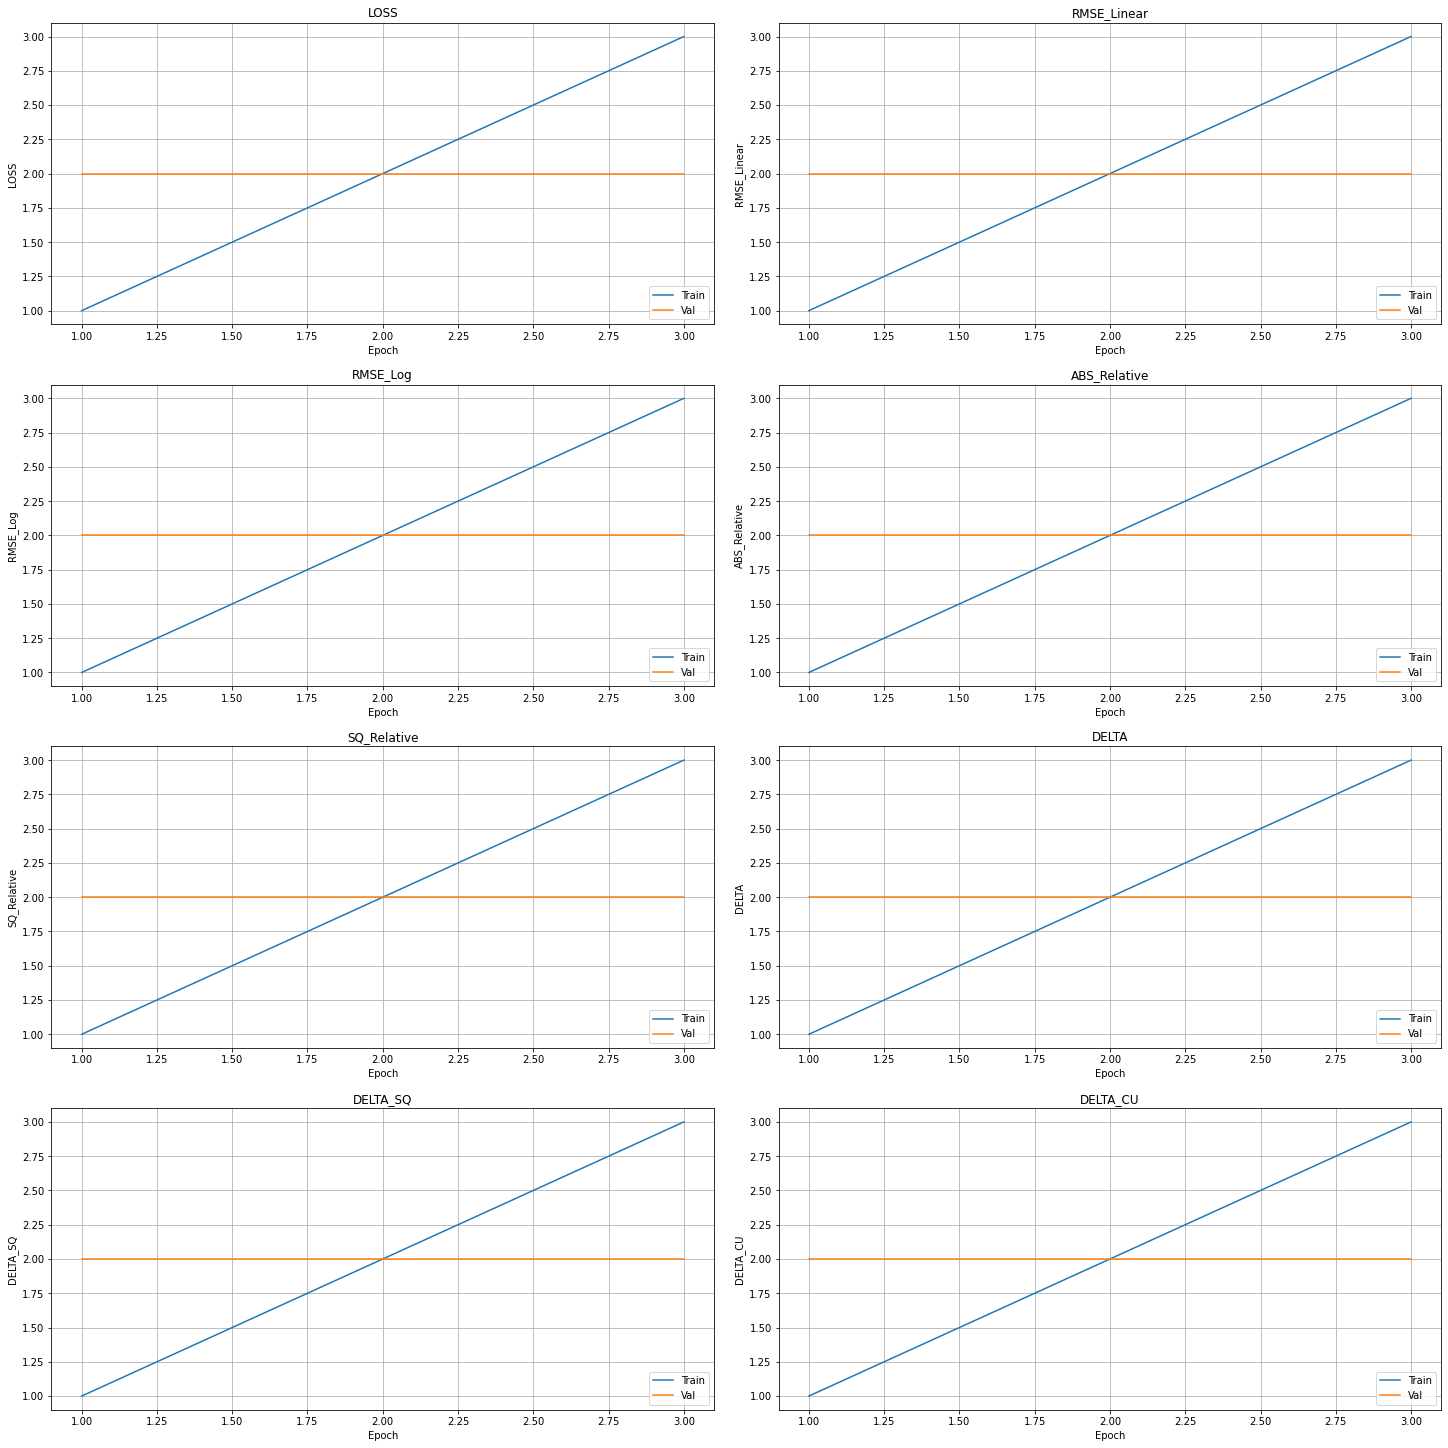

In [ ]:
#Test fig generation to plot the metric between train and validation
#The following code is embedded into ./src/main.py to plot metric during trainning the model
train_metrics = []
test_metrics = []

train_metrics.append((1, 1, 1, 1, 1, 1, 1, 1, 1))
train_metrics.append((2, 2, 2, 2, 2, 2, 2, 2, 2))
train_metrics.append((3, 3, 3, 3, 3, 3, 3, 3, 3))

test_metrics.append((1, 2, 2, 2, 2, 2, 2, 2, 2))
test_metrics.append((2, 2, 2, 2, 2, 2, 2, 2, 2))
test_metrics.append((3, 2, 2, 2, 2, 2, 2, 2, 2))

def plot_trainval_metric(df_train_metric, df_test_metric):
    fig, axes = plt.subplots(nrows=4, ncols=2, constrained_layout=True, figsize=(20,20))
    columns = ['LOSS', 'RMSE_Linear', 'RMSE_Log', 'ABS_Relative', 'SQ_Relative', 'DELTA', 'DELTA_SQ', 'DELTA_CU']
    
    for ax, column in zip(axes.flat, columns):
      ax.plot(df_train_metric['EPOCH'], df_train_metric[column], label='Train')
      ax.plot(df_test_metric['EPOCH'], df_test_metric[column], label='Val')
      ax.set_title(column)
      ax.set_ylabel(column)
      ax.set_xlabel('Epoch')
      ax.grid(True)
      ax.legend(loc="lower right")
     
    plt.show()
    fig.savefig("trainval_metric.pdf")

df_train_metric = pd.DataFrame(train_metrics, columns=['EPOCH', 'LOSS', 'RMSE_Linear', 'RMSE_Log', 'ABS_Relative', 'SQ_Relative', 'DELTA', 'DELTA_SQ', 'DELTA_CU'])
df_test_metric = pd.DataFrame(test_metrics, columns=['EPOCH', 'LOSS', 'RMSE_Linear', 'RMSE_Log', 'ABS_Relative', 'SQ_Relative', 'DELTA', 'DELTA_SQ', 'DELTA_CU'])
plot_trainval_metric(df_train_metric, df_test_metric)

In [ ]:
#Train and validate SDNet on ARGO-KITTI Dataset
#--pretrain ./results/sdn_sceneflow/sdn_sceneflow.pth
!python ./src/main.py --config ./src/configs/sdn_argo_train.config \
    --resume ./results/sdn_argo_train/checkpoint.pth.tar \
    --epochs 100 --eval_interval 1

[2020-08-08 06:55:56 main.py:111] INFO     arch: SDNet
[2020-08-08 06:55:56 main.py:111] INFO     argo: False
[2020-08-08 06:55:56 main.py:111] INFO     btrain: 4
[2020-08-08 06:55:56 main.py:111] INFO     bval: 1
[2020-08-08 06:55:56 main.py:111] INFO     calib_value: 1017
[2020-08-08 06:55:56 main.py:111] INFO     checkpoint_interval: 5
[2020-08-08 06:55:56 main.py:111] INFO     config: ./src/configs/sdn_argo_train.config
[2020-08-08 06:55:56 main.py:111] INFO     data_list: None
[2020-08-08 06:55:56 main.py:111] INFO     data_tag: None
[2020-08-08 06:55:56 main.py:111] INFO     data_type: depth
[2020-08-08 06:55:56 main.py:111] INFO     datapath: ../../Datasets/argoverse-tracking/training/
[2020-08-08 06:55:56 main.py:111] INFO     dataset: kitti
[2020-08-08 06:55:56 main.py:111] INFO     down: 2
[2020-08-08 06:55:56 main.py:111] INFO     dynamic_bs: False
[2020-08-08 06:55:56 main.py:111] INFO     epochs: 100
[2020-08-08 06:55:56 main.py:111] INFO     eval_interval: 1
[2020-08-08 0

Evaluation

In [ ]:
#Evaluate on test set
!python ./src/main.py --config ./src/configs/sdn_argo_train.config \
    --resume ./results/sdn_argo_train/checkpoint.pth.tar \
    --save_path ./results/sdn_argo_test \
    --split_val ./split/test_argo.txt \
    --evaluate

[2020-08-08 17:17:33 main.py:111] INFO     arch: SDNet
[2020-08-08 17:17:33 main.py:111] INFO     argo: False
[2020-08-08 17:17:33 main.py:111] INFO     btrain: 4
[2020-08-08 17:17:33 main.py:111] INFO     bval: 1
[2020-08-08 17:17:33 main.py:111] INFO     calib_value: 1017
[2020-08-08 17:17:33 main.py:111] INFO     checkpoint_interval: 5
[2020-08-08 17:17:33 main.py:111] INFO     config: ./src/configs/sdn_argo_train.config
[2020-08-08 17:17:33 main.py:111] INFO     data_list: None
[2020-08-08 17:17:33 main.py:111] INFO     data_tag: None
[2020-08-08 17:17:33 main.py:111] INFO     data_type: depth
[2020-08-08 17:17:33 main.py:111] INFO     datapath: ../../Datasets/argoverse-tracking/training/
[2020-08-08 17:17:33 main.py:111] INFO     dataset: kitti
[2020-08-08 17:17:33 main.py:111] INFO     down: 2
[2020-08-08 17:17:33 main.py:111] INFO     dynamic_bs: False
[2020-08-08 17:17:33 main.py:111] INFO     epochs: 300
[2020-08-08 17:17:33 main.py:111] INFO     eval_interval: 50
[2020-08-08 

Generate Predictions

In [ ]:
#Using the model trained on Argo-KITTI training set, and generating predictions on training + validation sets
!python ./src/main.py --config ./src/configs/sdn_argo_train.config \
    --resume ./results/sdn_argo_train/checkpoint.pth.tar \
    --save_path ./results/sdn_argo_trainval \
    --data_list ./split/trainval_argo.txt --generate_depth_map --data_tag trainval

[2020-08-08 17:29:48 main.py:111] INFO     arch: SDNet
[2020-08-08 17:29:48 main.py:111] INFO     argo: False
[2020-08-08 17:29:48 main.py:111] INFO     btrain: 4
[2020-08-08 17:29:48 main.py:111] INFO     bval: 1
[2020-08-08 17:29:48 main.py:111] INFO     calib_value: 1017
[2020-08-08 17:29:48 main.py:111] INFO     checkpoint_interval: 5
[2020-08-08 17:29:48 main.py:111] INFO     config: ./src/configs/sdn_argo_train.config
[2020-08-08 17:29:48 main.py:111] INFO     data_list: ./split/test_argo.txt
[2020-08-08 17:29:48 main.py:111] INFO     data_tag: test
[2020-08-08 17:29:48 main.py:111] INFO     data_type: depth
[2020-08-08 17:29:48 main.py:111] INFO     datapath: ../../Datasets/argoverse-tracking/training/
[2020-08-08 17:29:48 main.py:111] INFO     dataset: kitti
[2020-08-08 17:29:48 main.py:111] INFO     down: 2
[2020-08-08 17:29:48 main.py:111] INFO     dynamic_bs: False
[2020-08-08 17:29:48 main.py:111] INFO     epochs: 300
[2020-08-08 17:29:48 main.py:111] INFO     eval_interval

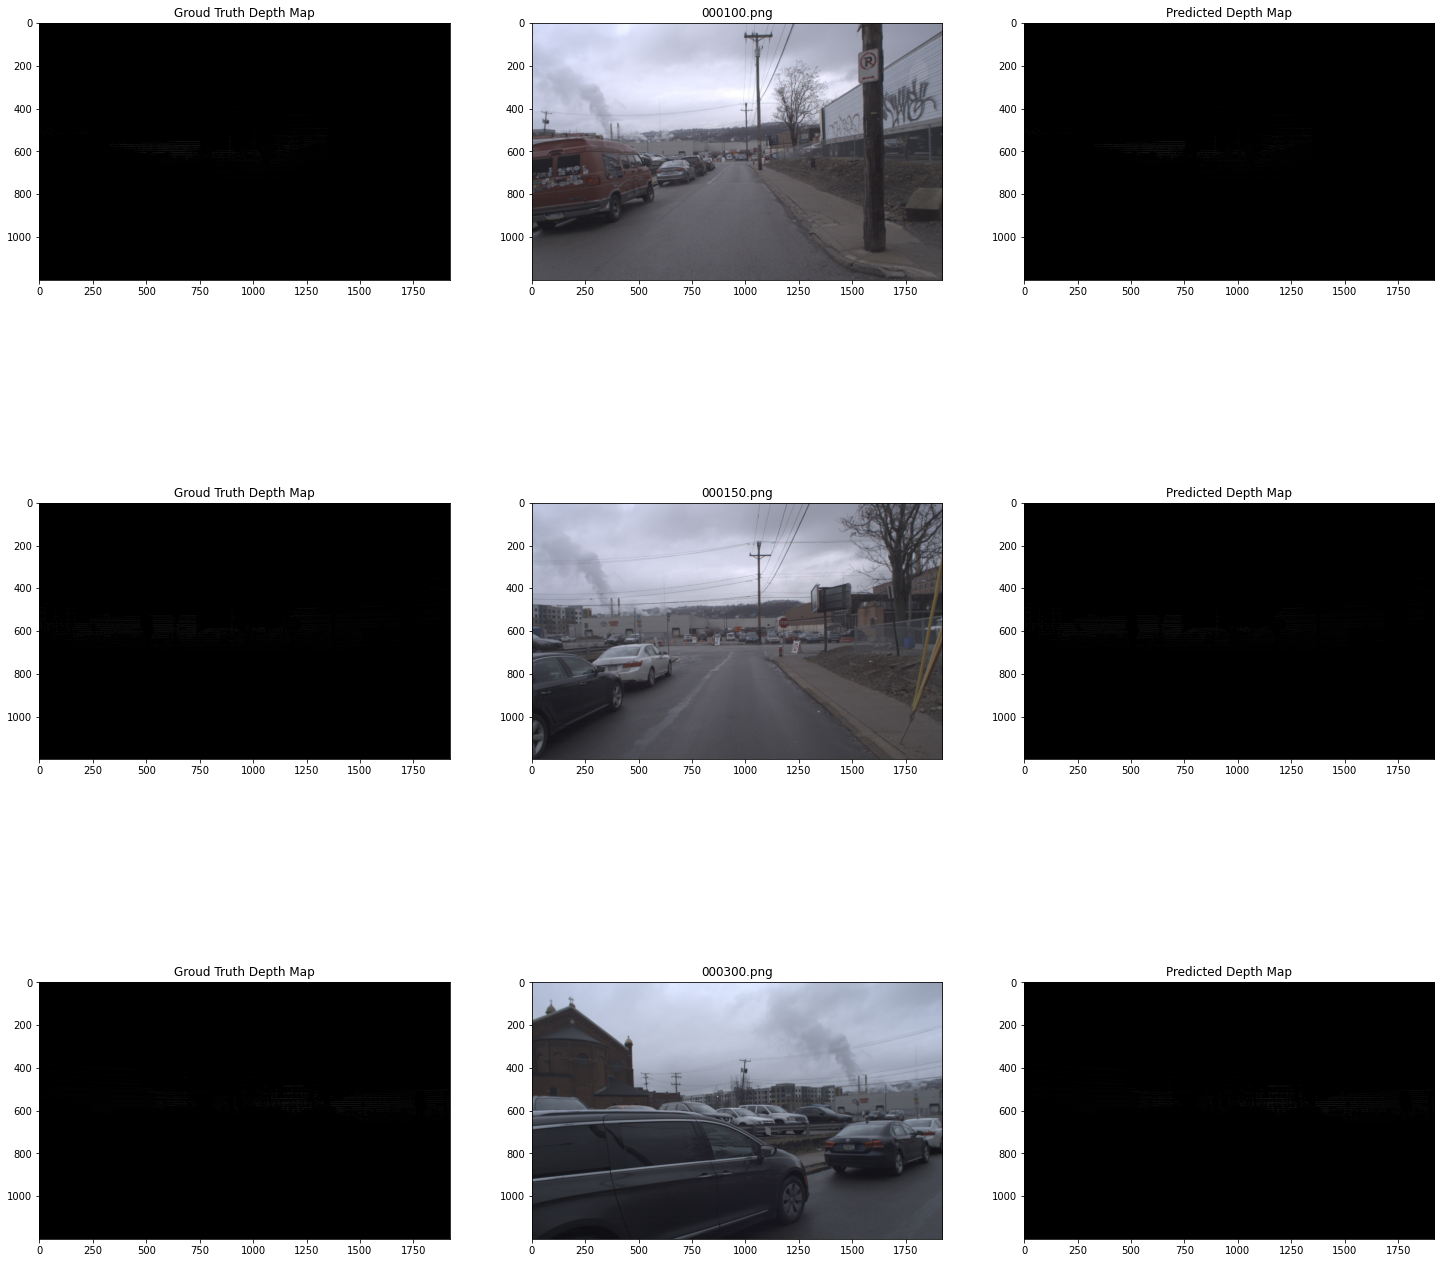

In [ ]:
#Compare ground truth and predicted depth map
fig, axes = plt.subplots(3, 3, figsize=(25, 25))

i = 0
for i, j in zip(range(3), ['100', '150', '300']):
  depth_map_dir = dataset_dir + 'depth_map/'
  img_array = np.load(depth_map_dir + '000' + j + '.npy', allow_pickle=True)
  axes[i,0].imshow(img_array, cmap="gray")
  axes[i,0].set_title('Groud Truth Depth Map')

  image_2 = dataset_dir + 'image_2/' 
  img = plt.imread(image_2 + '000' + j + '.png', 0)
  axes[i,1].imshow(img)
  axes[i,1].set_title('000' + j + '.png')

  predict_depth_map_dir = './results/sdn_argo_trainval/depth_maps/trainval/'
  predict_img_array = np.load(predict_depth_map_dir + '000' + j + '.npy', allow_pickle=True)
  axes[i,2].imshow(img_array, cmap="gray")
  axes[i,2].set_title('Predicted Depth Map')
plt.show()

fig.savefig("depth_map.pdf")

In [ ]:
#Using the model trained on Argo-KITTI training set, and generating predictions on testing sets
!python ./src/main.py --config ./src/configs/sdn_argo_train.config \
    --resume ./results/sdn_argo_train/checkpoint.pth.tar \
    --save_path ./results/sdn_argo_test \
    --data_list ./split/test_argo.txt --generate_depth_map --data_tag test

[2020-08-08 17:31:28 main.py:111] INFO     arch: SDNet
[2020-08-08 17:31:28 main.py:111] INFO     argo: False
[2020-08-08 17:31:28 main.py:111] INFO     btrain: 4
[2020-08-08 17:31:28 main.py:111] INFO     bval: 1
[2020-08-08 17:31:28 main.py:111] INFO     calib_value: 1017
[2020-08-08 17:31:28 main.py:111] INFO     checkpoint_interval: 5
[2020-08-08 17:31:28 main.py:111] INFO     config: ./src/configs/sdn_argo_train.config
[2020-08-08 17:31:28 main.py:111] INFO     data_list: ./split/test_argo.txt
[2020-08-08 17:31:28 main.py:111] INFO     data_tag: test
[2020-08-08 17:31:28 main.py:111] INFO     data_type: depth
[2020-08-08 17:31:28 main.py:111] INFO     datapath: ../../Datasets/argoverse-tracking/training/
[2020-08-08 17:31:28 main.py:111] INFO     dataset: kitti
[2020-08-08 17:31:28 main.py:111] INFO     down: 2
[2020-08-08 17:31:28 main.py:111] INFO     dynamic_bs: False
[2020-08-08 17:31:28 main.py:111] INFO     epochs: 300
[2020-08-08 17:31:28 main.py:111] INFO     eval_interval

Convert predictions to Pseudo-LiDAR and Planes

In [ ]:
# Convert depth maps to Pseudo-Lidar Point Clouds
!python ./src/preprocess/generate_lidar_from_depth.py \
    --calib_dir  ../../Datasets/argoverse-tracking/training/calib/ \
    --depth_dir ./results/sdn_argo_test/depth_maps/test/  \
    --save_dir  ./results/sdn_argo_test/pseudo_lidar/test/

Finish Depth 000000
Finish Depth 000003
Finish Depth 000005
Finish Depth 000016
Finish Depth 000025
Finish Depth 000026
Finish Depth 000033
Finish Depth 000036
Finish Depth 000037
Finish Depth 000038
Finish Depth 000039
Finish Depth 000045
Finish Depth 000049
Finish Depth 000051
Finish Depth 000055
Finish Depth 000059
Finish Depth 000060
Finish Depth 000064
Finish Depth 000065
Finish Depth 000072
Finish Depth 000074
Finish Depth 000081
Finish Depth 000083
Finish Depth 000084
Finish Depth 000090
Finish Depth 000100
Finish Depth 000105
Finish Depth 000119
Finish Depth 000122
Finish Depth 000128
Finish Depth 000135
Finish Depth 000136
Finish Depth 000143
Finish Depth 000144
Finish Depth 000152
Finish Depth 000153
Finish Depth 000156
Finish Depth 000159
Finish Depth 000166
Finish Depth 000167
Finish Depth 000168
Finish Depth 000170
Finish Depth 000171
Finish Depth 000172
Finish Depth 000185
Finish Depth 000197
Finish Depth 000202
Finish Depth 000210
Finish Depth 000212
Finish Depth 000213


In [ ]:
# Predict Ground Planes
!python ./src/preprocess/kitti_process_RANSAC.py \
    --calib_dir  ../../Datasets/argoverse-tracking/training/calib/ \
    --lidar_dir ./results/sdn_argo_test/pseudo_lidar/test/ \
    --planes_dir ./results/sdn_argo_test/pseudo_lidar/test_planes/

-------------  000000
[0, -1, 0]
1.65
-------------  000003
[0, -1, 0]
1.65
-------------  000005
[0, -1, 0]
1.65
-------------  000016
[0, -1, 0]
1.65
-------------  000025
[0, -1, 0]
1.65
-------------  000026
[0, -1, 0]
1.65
-------------  000033
[0, -1, 0]
1.65
-------------  000036
[0, -1, 0]
1.65
-------------  000037
[0, -1, 0]
1.65
-------------  000038
[0, -1, 0]
1.65
-------------  000039
[0, -1, 0]
1.65
-------------  000045
[0, -1, 0]
1.65
-------------  000049
[0, -1, 0]
1.65
-------------  000051
[0, -1, 0]
1.65
-------------  000055
[0, -1, 0]
1.65
-------------  000059
[0, -1, 0]
1.65
-------------  000060
[0, -1, 0]
1.65
-------------  000064
[0, -1, 0]
1.65
-------------  000065
[0, -1, 0]
1.65
-------------  000072
[0, -1, 0]
1.65
-------------  000074
[0, -1, 0]
1.65
-------------  000081
[0, -1, 0]
1.65
-------------  000083
[0, -1, 0]
1.65
-------------  000084
[0, -1, 0]
1.65
-------------  000090
[0, -1, 0]
1.65
-------------  000100
[0, -1, 0]
1.65
------------